# Behavior Cloning Project

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

The simulator can be found here:

https://github.com/udacity/self-driving-car-sim 
https://github.com/endymioncheung/CarND-MacCatalinaSimulator (macOS)

### Collecting Training Data
In order to start collecting training data, you'll need to do the following:

1. Enter Training Mode in the simulator.
2. Start driving the car to get a feel for the controls.
3. When you are ready, hit the record button in the top right to start recording.
4. Continue driving for a few laps or till you feel like you have enough data.
5. Hit the record button in the top right again to stop recording.

#### Strategies for Collecting Data

    the car should stay in the center of the road as much as possible
    if the car veers off to the side, it should recover back to center
    driving counter-clockwise can help the model generalize
    flipping the images is a quick way to augment the data
    collecting data from the second track can also help generalize the model
    we want to avoid overfitting or underfitting when training the model
    knowing when to stop collecting more data

Data will be saved from the recorder as follows:

1. IMG folder - this folder contains all the frames of your driving.
2. driving_log.csv - each row in this sheet correlates your image with the steering angle, throttle, brake, and speed of your car. You'll mainly be using the steering angle.


## Training The Network

I will use Keras to train a network to do the following:

1. Take in an image from the center camera of the car. This is the input to your neural network.
2. Output a new steering angle for the car.

The following network will be used to verify that everything is working properly and will be a flattened image connected to a single output node. 
This single output node will predict my steering angle, which makes this a regression network and no activation function will be applied. 
This will try to minimize the error that the network predicts and the ground truth steering measurement

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

lines = []
# Loading in the data from the csv file
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# Extracting the image and measurements 
images = []
measurements = []
for line in lines[1:]:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    
X_train = np.array(images)
y_train = np.array(measurements)

from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Flatten(input_shape = (160,320,3)))
model.add(Dense(1))

# Using mean square error for regression network
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle = True, nb_epoch=7)

model.save('model.h5')

NOTE: cv2.imread will get images in BGR format, while drive.py uses RGB. One way to keep the same image formatting is to do "image = ndimage.imread(current_path)" with "from scipy import ndimage" instead.



## Training The Network Continued 

I will use Keras to continue training the network by adding in the following:

### Lambda Layers
In Keras, lambda layers can be used to create arbitrary functions that operate on each image as it passes through the layer.

In this project, a lambda layer is a convenient way to parallelize image normalization. The lambda layer will also ensure that the model will normalize input images when making predictions in drive.py.

### Flipping Images And Steering Measurements
A effective technique for helping with the left turn bias involves flipping images and taking the opposite sign of the steering measurement. 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Lambda

lines = []
# Loading in the data from the csv file
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# Extracting the image and measurements 
images = []
measurements = []
for line in lines[1:]:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filename
    image = cv2.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)
    
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
# set up lambda layer for normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Flatten())
model.add(Dense(1))

# Using mean square error for regression network
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle = True, nb_epoch=1)

model.save('model.h5')

## Multiple Cameras

In a real car, we’ll have multiple cameras on the vehicle, and we’ll map recovery paths from each camera. For example, if you train the model to associate a given image from the center camera with a left turn, then you could also train the model to associate the corresponding image from the left camera with a somewhat softer left turn. And you could train the model to associate the corresponding image from the right camera with an even harder left turn.

In that way, you can simulate your vehicle being in different positions, somewhat further off the center line. To read more about this approach, see this paper by NVIDIA: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

Explanation of How Multiple Cameras Work

From the perspective of the left camera, the steering angle would be less than the steering angle from the center camera. From the right camera's perspective, the steering angle would be larger than the angle from the center camera. The next section will discuss how this can be implemented in your project although there is no requirement to use the left and right camera images.

Multiple Cameras in This Project

For this project, recording recoveries from the sides of the road back to center is effective. But it is also possible to use all three camera images to train the model. When recording, the simulator will simultaneously save an image for the left, center and right cameras. Each row of the csv log file, driving_log.csv, contains the file path for each camera as well as information about the steering measurement, throttle, brake and speed of the vehicle.

During training, I want to feed the left and right camera images to your model as if they were coming from the center camera. This way, you can teach your model how to steer if the car drifts off to the left or the right.

Figuring out how much to add or subtract from the center angle will involve some experimentation.

During prediction (i.e. "autonomous mode"), you only need to predict with the center camera image.

It is not necessary to use the left and right images to derive a successful model. Recording recovery driving from the sides of the road is also effective.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Lambda

lines = []
# Loading in the data from the csv file
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# create adjusted steering measurements for the side camera images
correction = 0.2 # this is a parameter to tune

# Extracting the image and measurements 
images = []
measurements = []
for line in lines[1:]:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path = 'data/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image)
        if i == 0: # Center
            measurement = float(line[3])
        elif i == 1: # Left
            measurement = float(line[3]) + correction
        elif i == 2: # Right
            measurement = float(line[3]) - correction        
        measurements.append(measurement)
    
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)
    
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
# set up lambda layer for normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Flatten())
model.add(Dense(1))

# Using mean square error for regression network
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle = True, nb_epoch=1)

model.save('model.h5')

## Cropping2D Layer

Keras provides the Cropping2D layer for image cropping within the model. This is relatively fast, because the model is parallelized on the GPU, so many images are cropped simultaneously.

By contrast, image cropping outside the model on the CPU is relatively slow.

Also, by adding the cropping layer, the model will automatically crop the input images when making predictions in drive.py.

The Cropping2D layer might be useful for choosing an area of interest that excludes the sky and/or the hood of the car.

Cropping Layer Code Example
    
    from keras.models import Sequential, Model
    from keras.layers import Cropping2D
    import cv2

    # set up cropping2D layer
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))


The example above crops:

* 50 rows pixels from the top of the image
* 20 rows pixels from the bottom of the image
* 0 columns of pixels from the left of the image
* 0 columns of pixels from the right of the image

## Network Architecture Updates

I am going to implement the NVIDIA Self Driving Car network published here: https://devblogs.nvidia.com/deep-learning-self-driving-cars/

The first layer of the network performs image normalization. The normalizer is hard-coded and is not adjusted in the learning process. Performing normalization in the network allows the normalization scheme to be altered with the network architecture, and to be accelerated via GPU processing.

The convolutional layers are designed to perform feature extraction, and are chosen empirically through a series of experiments that vary layer configurations. We then use strided convolutions in the first three convolutional layers with a 2×2 stride and a 5×5 kernel, and a non-strided convolution with a 3×3 kernel size in the final two convolutional layers.

We follow the five convolutional layers with three fully connected layers, leading to a final output control value which is the inverse-turning-radius. The fully connected layers are designed to function as a controller for steering, but we noted that by training the system end-to-end, it is not possible to make a clean break between which parts of the network function primarily as feature extractor, and which serve as controller.




In [ ]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Lambda, Cropping2D
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D

lines = []
# Loading in the data from the csv file
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# create adjusted steering measurements for the side camera images
correction = 0.2 # this is a parameter to tune

# Extracting the image and measurements 
images = []
measurements = []
for line in lines[1:]:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1]
        current_path = 'data/IMG/' + filename
        imageBGR = cv2.imread(current_path)
        # Images in drive.py are read in as RGB
        image = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
        images.append(image)
        if i == 0: # Center
            measurement = float(line[3])
        elif i == 1: # Left
            measurement = float(line[3]) + correction
        elif i == 2: # Right
            measurement = float(line[3]) - correction        
        measurements.append(measurement)

# Augmenting data to avoid left bias on the track
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)
    
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

model = Sequential()
# set up lambda layer for normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
# cropping 70 pixels from top of image (trees) and 25 pixels from bottom of image (hood of car)
model.add(Cropping2D(cropping=((70,25),(0,0))))

# NVIDIA architecture and including a dropout layer for redundancy
model.add(Conv2D(24,5,5, subsample = (2,2), activation = "relu"))
model.add(Conv2D(36,5,5, subsample = (2,2), activation = "relu"))
model.add(Conv2D(48,5,5, subsample = (2,2), activation = "relu"))
model.add(Conv2D(64,3,3, activation = "relu"))
model.add(Conv2D(64,3,3, activation = "relu"))
model.add(Flatten())
model.add(Dropout(0.5))   
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

# Using mean square error for regression network
model.compile(loss = 'mse', optimizer = 'adam')
model.fit(X_train, y_train, validation_split=0.2, shuffle = True, nb_epoch=5)

# Saving to file for use in drive.py
model.save('model.h5')

## Visualizin Loss

Outputting Training and Validation Loss Metrics
In Keras, the model.fit() and model.fit_generator() methods have a verbose parameter that tells Keras to output loss metrics as the model trains. The verbose parameter can optionally be set to verbose = 1 or verbose = 2.

Setting model.fit(verbose = 1) will

output a progress bar in the terminal as the model trains.
output the loss metric on the training set as the model trains.
output the loss on the training and validation sets after each epoch.
With model.fit(verbose = 2), Keras will only output the loss on the training set and validation set after each epoch.



In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=3, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Save the model
model.save('model.h5')

## Generators 

The images captured in the car simulator are much larger than the images encountered in the Traffic Sign Classifier Project, a size of 160 x 320 x 3 compared to 32 x 32 x 3. Storing 10,000 traffic sign images would take about 30 MB but storing 10,000 simulator images would take over 1.5 GB. That's a lot of memory! Not to mention that preprocessing data can change data types from an int to a float, which can increase the size of the data by a factor of 4.

Generators can be a great way to work with large amounts of data. Instead of storing the preprocessed data in memory all at once, using a generator you can pull pieces of the data and process them on the fly only when you need them, which is much more memory-efficient.

A generator is like a coroutine, a process that can run separately from another main routine, which makes it a useful Python function. Instead of using return, the generator uses yield, which still returns the desired output values but saves the current values of all the generator's variables. When the generator is called a second time it re-starts right after the yield statement, with all its variables set to the same values as before.



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
239/239 [==============================] - 183s 764ms/step - loss: 0.0247 - val_loss: 0.0167
Epoch 2/5
239/239 [==============================] - 178s 744ms/step - loss: 0.0213 - val_loss: 0.0175
Epoch 3/5
239/239 [==============================] - 172s 718ms/step - loss: 0.0202 - val_loss: 0.0149
Epoch 4/5
239/239 [==============================] - 167s 701ms/step - loss: 0.0193 - val_loss: 0.0156
Epoch 5/5
239/239 [==============================] - 168s 704ms/step - loss: 0.0186 - val_loss: 0.0146
dict_keys(['val_loss', 'loss'])


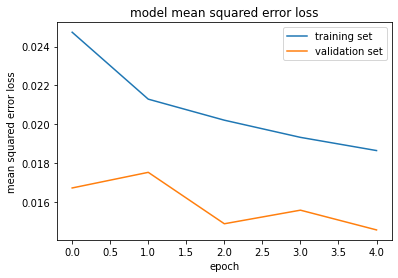

In [2]:
import os
import csv
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Lambda, Cropping2D
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv2D
import sklearn
from sklearn.utils import shuffle

samples1 = []
samples2 = []
samples = []
# Loading in the data from the csv file

with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples1.append(line)

with open('data/data2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples2.append(line)

samples = samples1[1:] + samples2

# create adjusted steering measurements for the side camera images
correction = 0.2 # this is a parameter to tune

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for line in batch_samples:
                for i in range(3):
                    source_path = line[i]
                    filename = source_path.split('/')[-1]
                    imageBGR = cv2.imread('data/IMG/' + filename)
                    if imageBGR is None:
                        imageBGR = cv2.imread('data/data2/IMG/' + filename)
                    # Images in drive.py are read in as RGB
                    image = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    if i == 0: # Center
                        measurement = float(line[3])
                    elif i == 1: # Left
                        measurement = float(line[3]) + correction
                    elif i == 2: # Right
                        measurement = float(line[3]) - correction        
                    measurements.append(measurement)

            # Augmenting data to avoid left bias on the track
            augmented_images, augmented_measurements = [], []
            for image, measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)
                
            # trim image to only see section with road
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

model = Sequential()
# set up lambda layer for normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
# cropping 70 pixels from top of image (trees) and 25 pixels from bottom of image (hood of car)
model.add(Cropping2D(cropping=((70,25),(0,0))))

# NVIDIA architecture and including a dropout layer for redundancy
model.add(Conv2D(24,5,5, subsample = (2,2), activation = "relu"))
model.add(Conv2D(36,5,5, subsample = (2,2), activation = "relu"))
model.add(Conv2D(48,5,5, subsample = (2,2), activation = "relu"))
model.add(Conv2D(64,3,3, activation = "relu"))
model.add(Conv2D(64,3,3, activation = "relu"))
model.add(Flatten())
model.add(Dropout(0.5))   
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, steps_per_epoch=np.ceil(len(train_samples)/batch_size), 
                    validation_data=validation_generator, 
                    validation_steps=np.ceil(len(validation_samples)/batch_size), 
                    epochs=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

# Save the model
model.save('model.h5')

## Validating The Network

In order to validate your network, you'll want to compare model performance on the training set and a validation set. The validation set should contain image and steering data that was not used for training. A rule of thumb could be to use 80% of your data for training and 20% for validation or 70% and 30%. Be sure to randomly shuffle the data before splitting into training and validation sets.

If model predictions are poor on both the training and validation set (for example, mean squared error is high on both), then this is evidence of underfitting. Possible solutions could be to

    increase the number of epochs
    add more convolutions to the network.
    
When the model predicts well on the training set but poorly on the validation set (for example, low mean squared error for training set, high mean squared error for validation set), this is evidence of overfitting. If the model is overfitting, a few ideas could be to

    use dropout or pooling layers
    use fewer convolution or fewer fully connected layers
    collect more data or further augment the data set
    
Ideally, the model will make good predictions on both the training and validation sets. The implication is that when the network sees an image, it can successfully predict what angle was being driven at that moment.

## Testing The Network

Once you're satisfied that the model is making good predictions on the training and validation sets, you can test your model by launching the simulator and entering autonomous mode.

The car will just sit there until your Python server connects to it and provides it steering angles. Here’s how you start your Python server:

    python drive.py model.h5

Once the model is up and running in drive.py, you should see the car move around (and hopefully not off) the track! If your model has low mean squared error on the training and validation sets but is driving off the track, this could be because of the data collection process. It's important to feed the network examples of good driving behavior so that the vehicle stays in the center and recovers when getting too close to the sides of the road.

In [3]:
!python drive.py model.h5 run2

Using TensorFlow backend.
/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/carnd-term1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/carnd-ter

-0.13709756731987 4.245576399999997
-0.13044114410877228 4.245231999999998
-0.13044114410877228 4.244857599999998
-0.13502520322799683 4.244432199999998
-0.0974203422665596 4.244097599999998
-0.0974203422665596 4.243722999999998
-0.11219150573015213 4.243297399999998
-0.0847754031419754 4.242931999999998
-0.0847754031419754 4.242556599999998
-0.07949494570493698 4.242079199999997
-0.10270482301712036 4.241742599999998
-0.10270482301712036 4.2413659999999975
-0.06753011792898178 4.240938399999998
-0.07177756726741791 4.240560799999998
-0.07177756726741791 4.240183199999999
-0.04458363354206085 4.239856599999999
-0.03629479557275772 4.239418799999999
-0.03629479557275772 4.2390409999999985
-0.03645763918757439 4.238683599999999
0.0026776606682687998 4.238295999999998
0.0026776606682687998 4.237918399999999
0.01653585024178028 4.237540799999999
0.03372758626937866 4.237173399999999
0.03372758626937866 4.236795999999999
0.029333526268601418 4.236459399999998
0.06219632551074028 4.236092999

0.09770217537879944 4.165416799999989
0.09200480580329895 4.16498019999999
0.09200480580329895 4.16460359999999
0.06877598911523819 4.164277999999991
0.03758779540657997 4.16386159999999
0.03758779540657997 4.1634851999999904
0.03214258700609207 4.16308839999999
0.04898539185523987 4.162680999999989
0.04898539185523987 4.16230359999999
0.045257825404405594 4.161926199999989
0.02506890706717968 4.161548799999989
0.02506890706717968 4.161171399999988
-0.00017323670908808708 4.160793999999989
-0.010338102467358112 4.160426799999988
-0.010338102467358112 4.160049599999988
-0.020680932328104973 4.159662199999988
-0.03296710550785065 4.159305199999987
-0.03296710550785065 4.158928199999987
-0.043682217597961426 4.1585613999999875
-0.01814773678779602 4.158194799999987
-0.01814773678779602 4.157818199999988
-0.038077462464571 4.157461999999988
-0.06721311062574387 4.157095999999989
-0.06721311062574387 4.156719999999988
-0.07442665845155716 4.1562929999999865
-0.07887586951255798 4.1559465999

-0.11700815707445145 4.085994199999981
-0.11700815707445145 4.085618599999981
-0.09100102633237839 4.0852327999999805
-0.09461991488933563 4.084897799999981
-0.09461991488933563 4.084522799999981
-0.09395743906497955 4.08413759999998
-0.09064001590013504 4.083670599999979
-0.09064001590013504 4.083293599999979
-0.08939715474843979 4.08292679999998
-0.09134867787361145 4.08254999999998
-0.09134867787361145 4.082173199999979
-0.09875129163265228 4.0817861999999785
-0.09281577169895172 4.081368399999979
-0.09281577169895172 4.0809905999999785
-0.0865618884563446 4.080663799999979
-0.06270378828048706 4.080307399999978
-0.06270378828048706 4.079930999999979
-0.08503882586956024 4.079534199999978
-0.0747530609369278 4.079147199999977
-0.0747530609369278 4.078770199999977
-0.07621996104717255 4.078362599999978
-0.06881727278232574 4.077995199999978
-0.06881727278232574 4.077617799999977
-0.05411442369222641 4.077250599999977
-0.045525092631578445 4.076883599999977
-0.045525092631578445 4.076

-0.07029245793819427 4.006102999999983
-0.09002328664064407 4.005726599999982
-0.09002328664064407 4.005350199999982
-0.11198465526103973 4.004953399999982
-0.09641796350479126 4.004545999999983
-0.09641796350479126 4.004168599999982
-0.08723891526460648 4.003831999999981
-0.06912350654602051 4.003526799999982
-0.06912350654602051 4.003151599999982
-0.07051452994346619 4.002704999999982
-0.07586543262004852 4.0023079999999815
-0.07586543262004852 4.001930999999982
-0.08863133937120438 4.0015437999999826
-0.07572950422763824 4.001156399999982
-0.07572950422763824 4.000778999999983
-0.08031228184700012 4.000411799999982
-0.08201923966407776 4.000075399999983
-0.08201923966407776 3.999698999999983
-0.09598557651042938 3.9992919999999823
-0.09279800951480865 3.998914999999983
-0.09279800951480865 3.9985379999999826
-0.08881451934576035 3.998201799999983
-0.08909109234809875 3.9977949999999822
-0.08909109234809875 3.9974181999999825
-0.08556244522333145 3.9970617999999822
-0.096587322652339

-0.08535932749509811 3.9278233999999874
-0.08535932749509811 3.9274469999999875
-0.07871062308549881 3.926999199999987
-0.053251493722200394 3.926611199999987
-0.053251493722200394 3.9262331999999867
-0.07683632522821426 3.9258551999999867
-0.07303090393543243 3.9254771999999862
-0.07303090393543243 3.9250991999999862
-0.05336509272456169 3.924731399999986
-0.07821359485387802 3.924373999999986
-0.07821359485387802 3.923996599999986
-0.08698081225156784 3.9236599999999857
-0.09233095496892929 3.923211999999986
-0.09233095496892929 3.922833999999986
-0.05666770040988922 3.922496799999986
-0.062136825174093246 3.9221501999999857
-0.062136825174093246 3.9217735999999856
-0.08147704601287842 3.9214071999999858
-0.07832352072000504 3.9209695999999856
-0.07832352072000504 3.920591999999986
-0.08944220840930939 3.920193999999986
-0.09842582792043686 3.9198873999999857
-0.09842582792043686 3.9195107999999856
-0.07656422257423401 3.919123999999986
-0.07753945142030716 3.918767599999986
-0.07753

-0.10399575531482697 3.8497823999999925
-0.10399575531482697 3.849404999999993
-0.09924529492855072 3.849088799999993
-0.05230153724551201 3.848732999999993
-0.05230153724551201 3.848357199999993
-0.05132975056767464 3.847991599999993
-0.03560934215784073 3.8475955999999933
-0.03560934215784073 3.847219599999993
-0.02703208476305008 3.846761999999993
-0.0014469961170107126 3.846384399999993
-0.0014469961170107126 3.8460067999999934
0.03450557589530945 3.8456291999999936
0.02347721718251705 3.8452617999999936
0.02347721718251705 3.844884399999994
0.002216217340901494 3.844537599999994
0.011881861835718155 3.8442117999999943
0.011881861835718155 3.8438359999999943
0.03218492493033409 3.8434703999999944
0.010216730646789074 3.8430233999999945
0.010216730646789074 3.8426463999999947
0.01950911246240139 3.842269399999995
0.014667165465652943 3.8419535999999948
0.014667165465652943 3.841577799999995
0.030494583770632744 3.841140799999995
0.018530836328864098 3.840763799999995
0.0185308363288

0.06069520488381386 3.768895000000001
0.04571092873811722 3.768497800000001
0.04571092873811722 3.7681206000000014
0.04138753563165665 3.767753600000001
0.036210574209690094 3.7673766000000013
0.036210574209690094 3.7669996000000014
0.02287873439490795 3.7666124000000014
0.017848649993538857 3.7662352000000014
0.017848649993538857 3.7658580000000015
0.018162989988923073 3.765480800000002
0.011175675317645073 3.765093400000002
0.011175675317645073 3.764716000000002
0.008556903339922428 3.7643488000000023
-0.0023850963916629553 3.7639716000000023
-0.0023850963916629553 3.7635944000000023
0.004041005857288837 3.7632172000000024
-0.01140108797699213 3.7759878000000024
-0.01140108797699213 3.7758684000000025
-0.0209787767380476 3.7754124000000022
-0.020586945116519928 3.7748580000000023
-0.020586945116519928 3.7747236000000024
-0.026435120031237602 3.7742220000000026
-0.03230860084295273 3.7648494000000023
-0.03230860084295273 3.7645268000000027
-0.0017695247661322355 3.7979356000000024
0.0

-0.01627323031425476 3.6917143999999875
-0.01627323031425476 3.6913379999999876
-0.0038172921631485224 3.690961599999987
-0.025218619033694267 3.6905851999999872
-0.025218619033694267 3.6902087999999873
-0.039973486214876175 3.689832399999987
-0.013601859100162983 3.689455999999987
-0.013601859100162983 3.6890795999999866
-0.00010059797205030918 3.688713399999987
-0.022031767293810844 3.6883575999999865
-0.022031767293810844 3.687981799999987
-0.003480565035715699 3.6875651999999866
-0.009155462495982647 3.6871987999999867
-0.009155462495982647 3.6868223999999867
-0.00030524772591888905 3.686445999999987
0.01074677612632513 3.686059399999986
0.01074677612632513 3.685682799999986
0.009554598480463028 3.685306199999986
0.03036011941730976 3.684939799999986
0.03036011941730976 3.6845633999999863
0.029284482821822166 3.684197199999986
0.018929045647382736 3.683810799999986
0.018929045647382736 3.683434399999986
0.030234044417738914 3.683088599999986
0.03132651373744011 3.682702599999986
0.

-0.11020474135875702 3.613033999999972
-0.11020474135875702 3.6126587999999717
-0.10606774687767029 3.612181599999972
-0.11633037030696869 3.611804399999972
-0.11633037030696869 3.611427199999972
-0.07659345865249634 3.611039799999972
-0.07274049520492554 3.6106623999999723
-0.07274049520492554 3.610284999999972
-0.04974367842078209 3.6099381999999727
-0.04248199984431267 3.6095001999999723
-0.04248199984431267 3.6091221999999723
-0.05414199084043503 3.6087441999999723
-0.04823658615350723 3.608376399999972
-0.04823658615350723 3.6079985999999717
-0.005325591191649437 3.6076309999999716
-0.025454949587583542 3.607253399999972
-0.025454949587583542 3.606875799999972
-0.02370716817677021 3.6064981999999723
-0.013393823057413101 3.6061613999999724
-0.013393823057413101 3.6057845999999723
-0.004590492695569992 3.6053873999999726
0.011078070849180222 3.6049999999999724
0.011078070849180222 3.604622599999973
0.01879226602613926 3.604255399999973
0.051409415900707245 3.603878199999973
0.05140

-0.193706214427948 3.534275199999975
-0.193706214427948 3.533899599999975
-0.23216673731803894 3.533503599999975
-0.2114981859922409 3.533178599999975
-0.2114981859922409 3.532803599999975
-0.21060390770435333 3.5321939999999747
-0.22965285181999207 3.532110199999974
-0.22965285181999207 3.5317363999999745
-0.20890773832798004 3.531229999999975
-0.2290874570608139 3.530863799999975
-0.2290874570608139 3.5304875999999745
-0.2210034728050232 3.530233799999974
-0.2250221073627472 3.5297273999999748
-0.2250221073627472 3.529350999999975
-0.22584685683250427 3.5291173999999743
-0.2095007747411728 3.5286825999999745
-0.2095007747411728 3.528307799999974
-0.22143806517124176 3.527953399999974
-0.18104740977287292 3.527680999999974
-0.18104740977287292 3.527308599999974
-0.19950754940509796 3.5268137999999736
-0.16276142001152039 3.526510399999974
-0.16276142001152039 3.526136999999974
-0.14984358847141266 3.525528999999974
-0.14185602962970734 3.525252999999974
-0.14185602962970734 3.52487699

-0.0011472792830318213 3.455145599999976
-0.0011472792830318213 3.4547685999999755
0.011119266971945763 3.454401799999976
-7.586437277495861e-05 3.4540351999999754
-7.586437277495861e-05 3.4536585999999754
-0.021870333701372147 3.453261599999976
-0.006391520611941814 3.4528845999999755
-0.006391520611941814 3.4525075999999757
0.008011383935809135 3.452130599999976
0.003551195142790675 3.4517637999999757
0.003551195142790675 3.451386999999976
0.00013676402159035206 3.450989799999976
-0.0034558174666017294 3.450622799999976
-0.0034558174666017294 3.450245799999976
-0.03027922846376896 3.4498585999999762
-0.05145072564482689 3.4494813999999763
-0.05145072564482689 3.4491041999999763
-0.06810449063777924 3.4487371999999765
-0.05548642575740814 3.448380599999976
-0.05548642575740814 3.448003999999976
-0.04144929721951485 3.4476783999999765
-0.06381068378686905 3.4473231999999765
-0.06381068378686905 3.446947999999977
-0.06022804230451584 3.4465217999999767
-0.044651422649621964 3.4461149999

0.3007833957672119 3.3754289999999783
0.3007833957672119 3.3750559999999785
0.3032233417034149 3.374662599999979
0.3040938973426819 3.3743707999999786
0.3040938973426819 3.3739989999999787
0.273377925157547 3.3738005999999787
0.29849880933761597 3.3734117999999786
0.29849880933761597 3.3730429999999783
0.3029371500015259 3.372663999999978
0.3169156014919281 3.3720705999999785
0.3169156014919281 3.3716971999999785
0.3246350586414337 3.371476799999979
0.38434669375419617 3.371106399999979
0.38434669375419617 3.3707359999999795
0.3584045469760895 3.370477799999979
0.3310612440109253 3.370150399999979
0.3310612440109253 3.369782999999979
0.3682596981525421 3.370078599999979
0.32297712564468384 3.3694385999999787
0.32297712564468384 3.3690785999999786
0.35785728693008423 3.3681983999999785
0.292273610830307 3.368113799999979
0.292273610830307 3.367749199999979
0.2691253125667572 3.367109199999979
0.2857118844985962 3.366953399999979
0.2857118844985962 3.366587599999979
0.26043701171875 3.36

-0.0047095762565732 3.294699999999986
0.006252676248550415 3.294322799999986
-0.008444425649940968 3.293945599999986
-0.008444425649940968 3.293568399999986
0.0052740853279829025 3.2932013999999863
-0.0038508696015924215 3.2928141999999863
-0.0038508696015924215 3.2924369999999863
-0.021570337936282158 3.2920699999999865
-0.003750545671209693 3.2916929999999867
-0.003750545671209693 3.2913159999999864
0.0015580898616462946 3.2909287999999868
0.011768517084419727 3.2905719999999867
0.011768517084419727 3.2901951999999866
0.005246852524578571 3.289797999999987
-0.014211474917829037 3.2894309999999867
-0.014211474917829037 3.289053999999987
-0.007415594533085823 3.288676999999987
0.011466237716376781 3.288299999999987
0.011466237716376781 3.287922999999987
-0.0042855143547058105 3.287545999999987
0.011658853851258755 3.287158799999987
0.011658853851258755 3.286781599999987
0.005339155904948711 3.286414599999987
-0.007279811426997185 3.2860375999999873
-0.007279811426997185 3.2856605999999

-0.08269115537405014 3.2168301999999875
-0.0891498550772667 3.2164723999999874
-0.12591032683849335 3.2160843999999873
-0.12591032683849335 3.215706399999987
-0.002156458329409361 3.215307999999987
0.0846482515335083 3.2149499999999867
0.0846482515335083 3.2145719999999867
0.09212981909513474 3.214306199999987
0.0696263238787651 3.213858999999987
0.0696263238787651 3.213481799999987
0.0818883553147316 3.2137063999999866
0.09655266255140305 3.2131879999999873
0.09655266255140305 3.212819599999987
0.11716433614492416 3.212185999999987
0.08650150895118713 3.211842999999987
0.08650150895118713 3.2114699999999874
0.10204615443944931 3.2111275999999873
0.09690588712692261 3.2108265999999865
0.09690588712692261 3.2104555999999866
0.08890759199857712 3.209870399999987
0.040960218757390976 3.2095359999999866
0.040960218757390976 3.2091615999999865
0.03973373770713806 3.2087463999999866
0.008936264552175999 3.208350799999987
0.008936264552175999 3.207975199999987
0.011786896735429764 3.207517999

-0.24530449509620667 3.137914199999989
-0.24530449509620667 3.137545199999989
-0.22307129204273224 3.1370027999999888
-0.27652302384376526 3.136977199999989
-0.27652302384376526 3.1366115999999886
-0.28726375102996826 3.1361643999999886
-0.3105970323085785 3.1355829999999885
-0.3105970323085785 3.1352115999999883
-0.2774417996406555 3.135237999999988
-0.28448984026908875 3.1348641999999884
-0.28448984026908875 3.1345003999999883
-0.25053325295448303 3.1342793999999885
-0.24432219564914703 3.1335307999999884
-0.24432219564914703 3.133162199999989
-0.23088338971138 3.1327425999999887
-0.2104971706867218 3.132066999999989
-0.2104971706867218 3.131691399999989
-0.20431911945343018 3.1312953999999893
-0.19254787266254425 3.130858199999989
-0.19254787266254425 3.130480999999989
-0.17500288784503937 3.130042599999989
-0.15057890117168427 3.129653999999989
-0.15057890117168427 3.129275399999989
-0.1335405707359314 3.1288865999999893
-0.14035442471504211 3.1284873999999894
-0.14035442471504211 

-0.14704746007919312 3.0589021999999892
-0.14704746007919312 3.058527799999989
-0.1446790248155594 3.058163599999989
-0.14627604186534882 3.0577485999999894
-0.14627604186534882 3.0573735999999894
-0.15323832631111145 3.056896599999989
-0.131980299949646 3.0565093999999893
-0.131980299949646 3.0561321999999893
-0.11460425704717636 3.0557753999999893
-0.1369321048259735 3.055429199999989
-0.1369321048259735 3.0550529999999894
-0.14751961827278137 3.054605399999989
-0.1287267804145813 3.054207399999989
-0.1287267804145813 3.053829399999989
-0.134555384516716 3.0535227999999885
-0.10689721256494522 3.0531869999999888
-0.10689721256494522 3.052811199999989
-0.1280568391084671 3.052363999999989
-0.12989287078380585 3.052017399999989
-0.12989287078380585 3.051640799999989
-0.09831614792346954 3.051202999999989
-0.08917970210313797 3.050896599999989
-0.08917970210313797 3.050520199999989
-0.0615762397646904 3.0501437999999887
-0.07990638166666031 3.049644999999989
-0.07990638166666031 3.04926

0.1672099232673645 2.9795973999999914
0.17994344234466553 2.979518599999991
0.19059301912784576 2.9790783999999917
0.19059301912784576 2.978708199999992
0.16293303668498993 2.978327799999992
0.12441222369670868 2.977967599999992
0.12441222369670868 2.977597399999992
0.13603399693965912 2.977216999999993
0.13651536405086517 2.976622199999992
0.13651536405086517 2.976247399999992
0.1493455469608307 2.9757399999999925
0.13053061068058014 2.9754033999999923
0.13053061068058014 2.975026799999992
0.1162356436252594 2.974650199999992
0.12619765102863312 2.9743245999999925
0.12619765102863312 2.9739489999999926
0.07256542146205902 2.9735019999999928
0.04190940409898758 2.9731045999999925
0.04190940409898758 2.972727199999993
0.014536178670823574 2.972380399999993
0.013024508021771908 2.971932199999993
0.013024508021771908 2.9715539999999927
-0.01517463754862547 2.9712063999999927
-0.06319275498390198 2.970838999999993
-0.06319275498390198 2.970461599999993
-0.07640543580055237 2.97009439999999

-0.1761520355939865 2.900640399999992
-0.18072828650474548 2.900265999999992
-0.18072828650474548 2.8998915999999917
-0.15114666521549225 2.8994457999999916
-0.14417675137519836 2.899018999999992
-0.14417675137519836 2.898642199999992
-0.15187297761440277 2.8982959999999918
-0.1171950027346611 2.8978279999999916
-0.1171950027346611 2.897449999999991
-0.0944070965051651 2.897071999999991
-0.08626314252614975 2.896734799999991
-0.08626314252614975 2.896357599999991
-0.057489871978759766 2.8959191999999914
127.0.0.1 - - [26/May/2020 13:09:06] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 145.626045
^C
wsgi exiting
(36006) wsgi exited, is_accepting=True


The fourth argument, run1, is the directory in which to save the images seen by the agent. If the directory already exists, it'll be overwritten.

The image file name is a timestamp of when the image was seen.. This information is used by video.py to create a chronological video of the agent driving.

Using video.py

    python video.py run1
    
Creates a video based on images found in the run1 directory. The name of the video will be the name of the directory followed by '.mp4', so, in this case the video will be run1.mp4.

Optionally, one can specify the FPS (frames per second) of the video:

    python video.py run1 --fps 48
    
The video will run at 48 FPS. The default FPS is 60.



In [4]:
!python video.py run2

Creating video run2, FPS=60
Moviepy - Building video run2.mp4.
Moviepy - Writing video run2.mp4

Moviepy - Done !                                                                
Moviepy - video ready run2.mp4
